## Importing Libraries

In [6]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict
from pandas import DataFrame
import seaborn as sns

## Cleaning and K Means

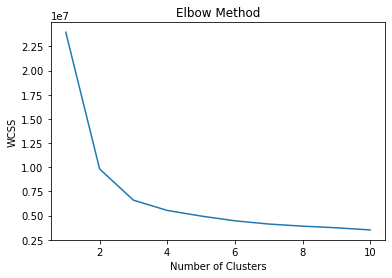

              Total          HP      Attack     Defense     Sp. Atk  \
Cluster                                                               
0        526.314286   76.471429   71.150000   80.578571  112.042857   
1        498.845638  110.040268  100.630872   81.342282   73.134228   
2        298.230570   49.365285   53.525907   50.784974   47.106218   
3        635.082707   93.022556  127.210526   98.518797  114.541353   
4        456.839080   68.340996   87.532567   66.877395   73.191571   
5        479.768000   66.152000   90.176000  123.960000   63.336000   

            Sp. Def       Speed  
Cluster                          
0        104.300000   81.771429  
1         75.040268   58.657718  
2         48.217617   49.230570  
3         96.526316  105.263158  
4         68.318008   92.578544  
5         88.416000   47.728000  
Type1     Bug  Dark  Dragon  Electric  Fairy  Fighting  Fire  Flying  Ghost  \
Cluster                                                                       
0

In [7]:
def remove_words_before(name: str) -> str:
    """
    Remove words before specified words in a name.
    
    Args:
    - name (str): Name to process
    
    Returns:
    - str: Name with words before specified words removed
    """
    specified_words = ['Mega', 'Alolan', 'Partner', 'Hisuian', 'Galarian', 'Paldean', 'Primal', 'Heat', 'Wash',
                       'Frost', 'Fan', 'Mow', 'White', 'Black', 'Dusk Mane', 'Dawn Wings', 'Ultra']
    for word in specified_words:
        name = re.sub(r'.*?(?='+re.escape(word)+')', '', name)
    return name.strip()


def preprocess_data(data: DataFrame) -> DataFrame:
    """
    Preprocess the Pokémon data by removing words before specified words in the 'Names' column.
    
    Args:
    - data (DataFrame): Input DataFrame
    
    Returns:
    - DataFrame: Preprocessed DataFrame
    """
    data['Names_clean'] = data['Names'].apply(remove_words_before)
    return data


def perform_kmeans_clustering(data: DataFrame, selected_features: List[str], num_clusters: int) -> DataFrame:
    """
    Perform k-means clustering on the selected features of the Pokémon data.
    
    Args:
    - data (DataFrame): Input DataFrame
    - selected_features (list): List of selected features
    - num_clusters (int): Number of clusters to generate
    
    Returns:
    - DataFrame: DataFrame with cluster labels assigned
    """
    pokemon_features = data[selected_features]
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(pokemon_features)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(normalized_features)

    data['Cluster'] = kmeans.labels_

    return data


def analyze_clusters(data: DataFrame, selected_features: List[str]) -> Tuple[DataFrame, DataFrame]:
    """
    Analyze the clusters based on their mean values and type counts.
    
    Args:
    - data (DataFrame): Input DataFrame with cluster labels
    - selected_features (list): List of selected features
    
    Returns:
    - DataFrame: Cluster means of selected features
    - DataFrame: Type counts within each cluster
    """
    cluster_means = data.groupby('Cluster')[selected_features].mean()
    type_counts = data.groupby(['Cluster', 'Type1'])['Id'].count().unstack()
    return cluster_means, type_counts


def save_data_to_csv(data: DataFrame, filename: str) -> None:
    """
    Save the Pokémon data with cluster labels to a CSV file.
    
    Args:
    - data (DataFrame): Input DataFrame
    - filename (str): File name for the CSV
    
    Returns:
    - None
    """
    data.drop('Unnamed: 0', axis=1, inplace=True)
    data.to_csv(filename, index=False)
    print(f"Data saved to {filename}")


def plot_elbow_method(data: DataFrame, selected_features: List[str], max_clusters: int) -> None:
    """
    Plot the elbow method to determine the optimal number of clusters.
    
    Args:
    - data (DataFrame): Input DataFrame for clustering
    - selected_features (list): List of selected features
    - max_clusters (int): Maximum number of clusters to consider
    
    Returns:
    - None
    """
    wcss = []
    for n in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), wcss)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method')
    plt.show()


# Read the Pokémon data from CSV
pokemon_data = pd.read_csv('../Downloads/pokemon.csv')

# Preprocess the data
pokemon_data = preprocess_data(pokemon_data)

# Set the desired features for clustering
selected_features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

# Plot the elbow method to determine the optimal number of clusters
max_clusters = 10
plot_elbow_method(pokemon_data[selected_features], selected_features, max_clusters)

# Perform k-means clustering
num_clusters = 6
pokemon_data = perform_kmeans_clustering(pokemon_data, selected_features, num_clusters)

# Analyze the clusters
cluster_means, type_counts = analyze_clusters(pokemon_data, selected_features)
print(cluster_means)
print(type_counts)

# Save the data with cluster labels to a new CSV file
save_data_to_csv(pokemon_data, 'pokemon_cluster.csv')


## Exploring Crosstabs Plots

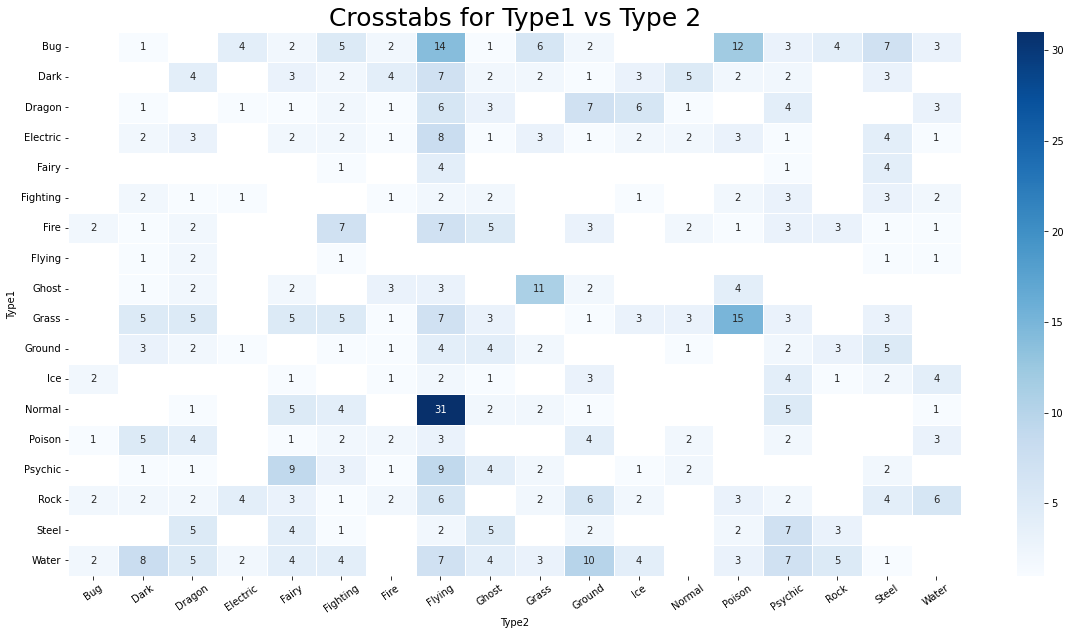

In [18]:

def plot_heatmap(data: DataFrame, index: str, columns: str, values: str = 'None', figsize: tuple = (20, 10)) -> None:
    """
    Plot a heatmap for the given data with specified index, columns, and values.
    
    Args:
    - data (DataFrame): Input DataFrame
    - index (str): Column name for the index
    - columns (str): Column name for the columns
    - values (str): Column name for the values
    - figsize (tuple): Figure size (default: (20, 10))
    
    Returns:
    - None
    """
    
    if values != 'None':
        
        plt.subplots(figsize=figsize)

        heatmap_data = data[data[columns] != 'None'].pivot_table(index=index, columns=columns, values=values, aggfunc='mean')

        sns.heatmap(
            heatmap_data,
            linewidths=1,
            annot=True,
            fmt='.2f',  # Set the number format to two decimal places
            cmap="Blues"
        )

        plt.xticks(rotation=35)
        plt.title(f'Average {values} for Type1 vs Type2', fontsize=25)
        plt.show()
    else:
        plt.subplots(figsize=figsize)
        sns.heatmap(
        pokemon_data[pokemon_data['Type2']!='None'].groupby(['Type1', 'Type2']).size().unstack(),
        linewidths=1,
        annot=True,
        cmap="Blues")
        
        plt.xticks(rotation=35)
        plt.title('Crosstabs for Type1 vs Type 2', fontsize=25)
        plt.show()
        
        

# Plot the size heatmap for 'Type1' and 'Type2'
plot_heatmap(pokemon_data, 'Type1', 'Type2', figsize=(20, 10))




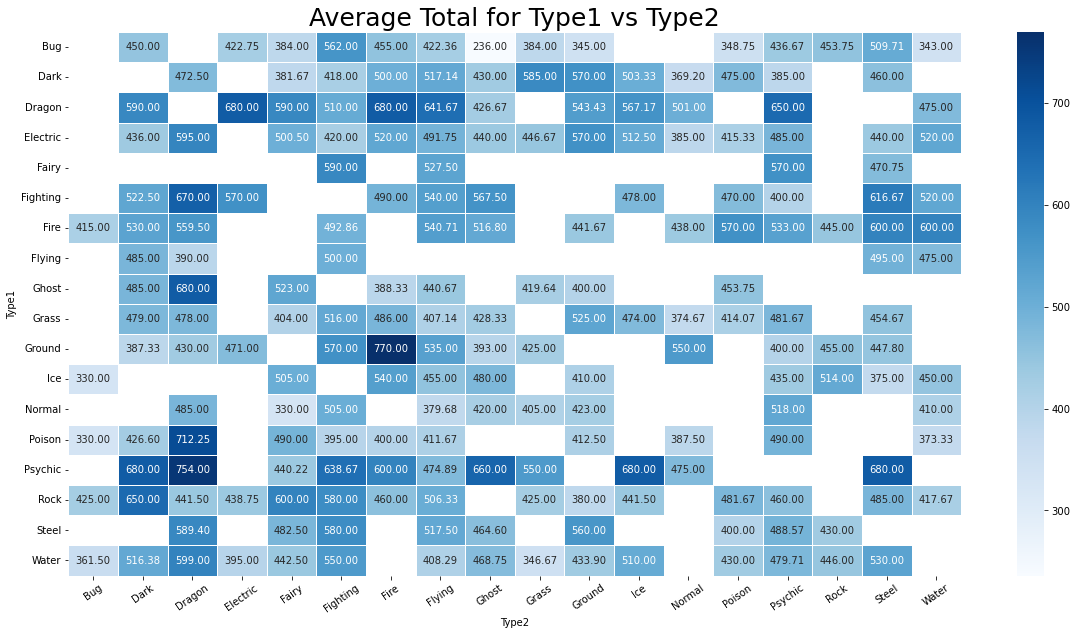

In [19]:
# Plot the heatmap for 'Total' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Total', figsize=(20, 10))

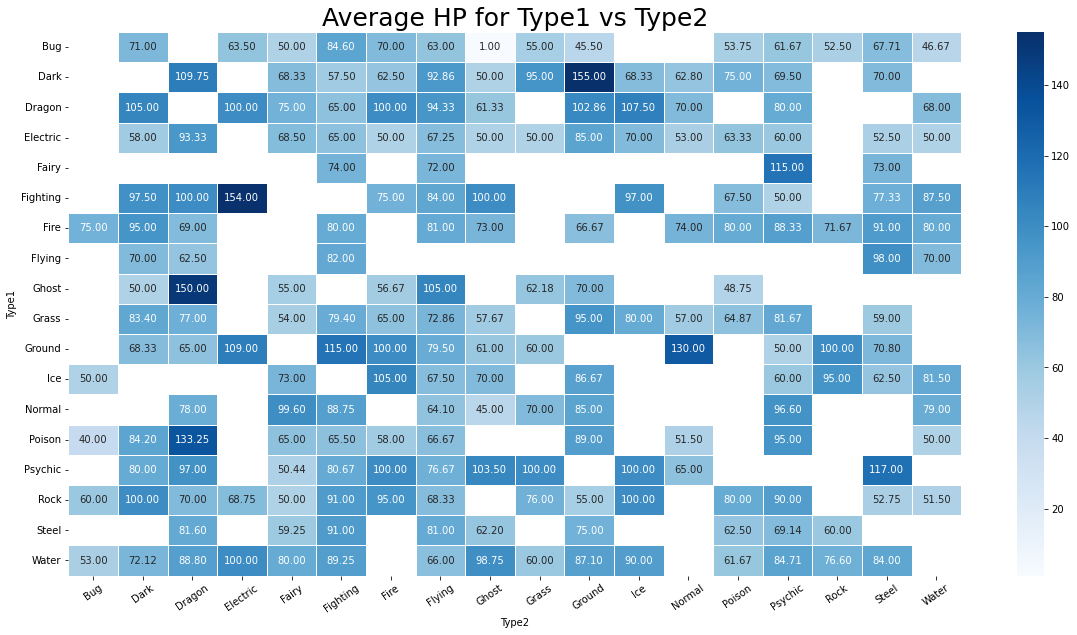

In [20]:
# Plot the heatmap for 'HP' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'HP', figsize=(20, 10))

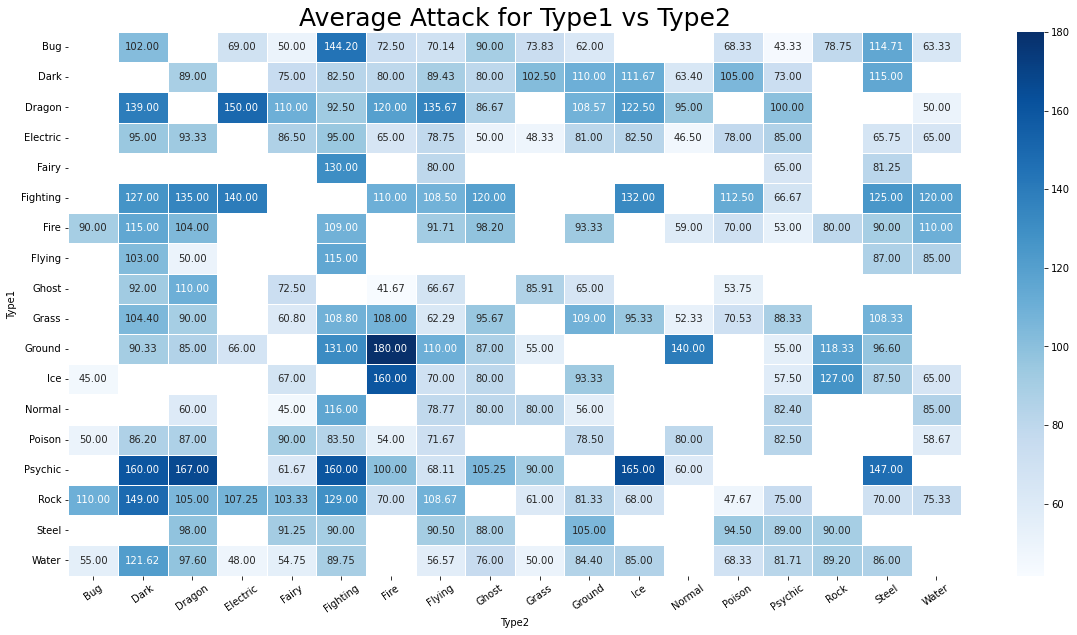

In [21]:
# Plot the heatmap for 'Attack' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Attack', figsize=(20, 10))

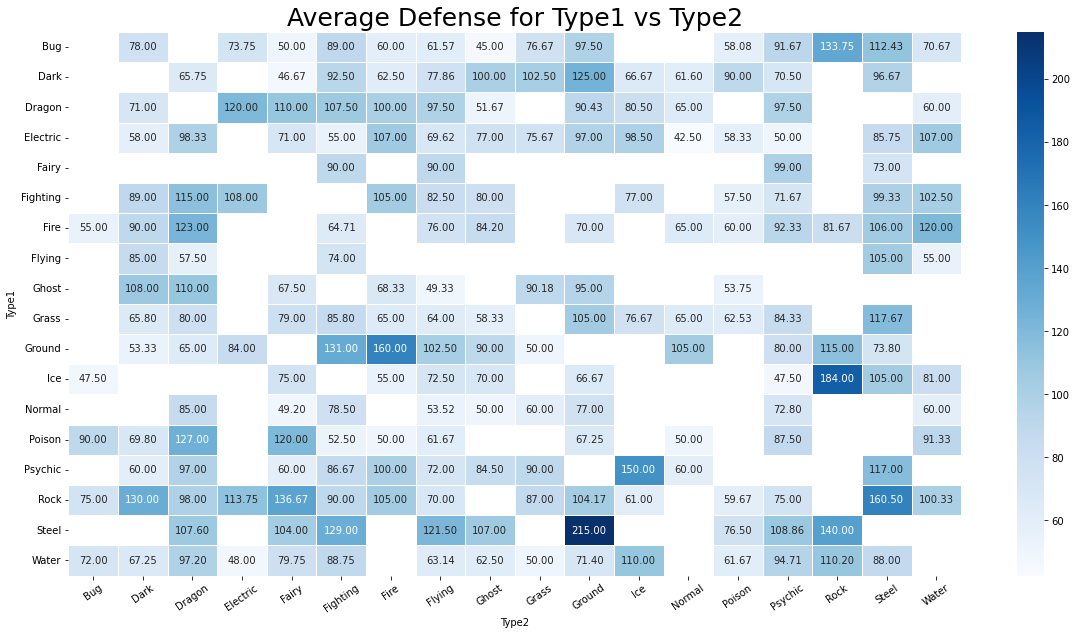

In [22]:
# Plot the heatmap for 'Defense' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Defense', figsize=(20, 10))

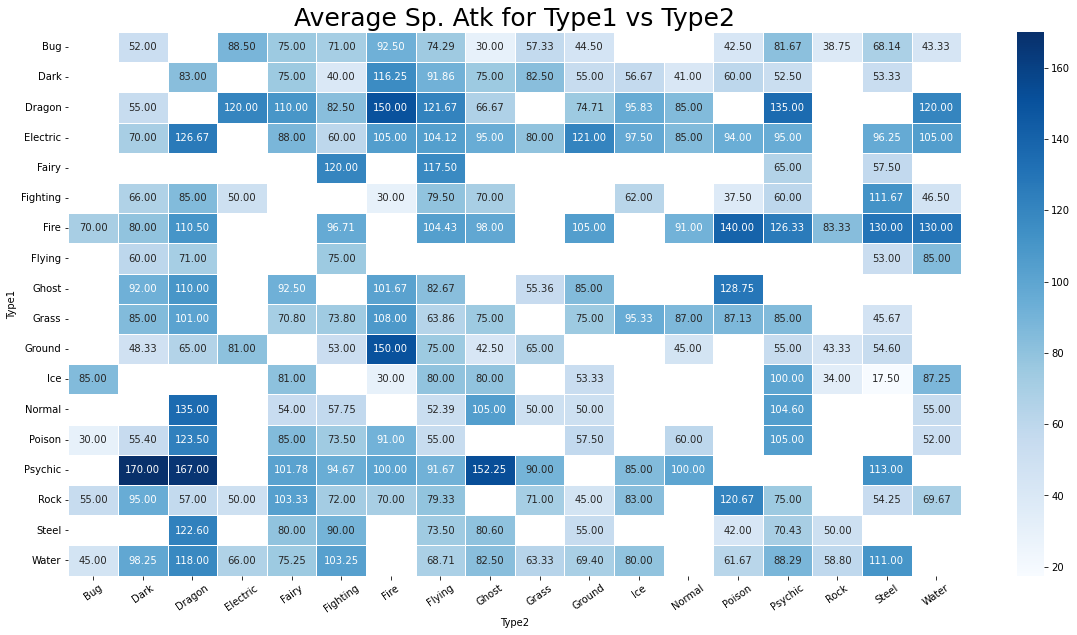

In [23]:
# Plot the heatmap for 'Sp. Atk' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Sp. Atk', figsize=(20, 10))

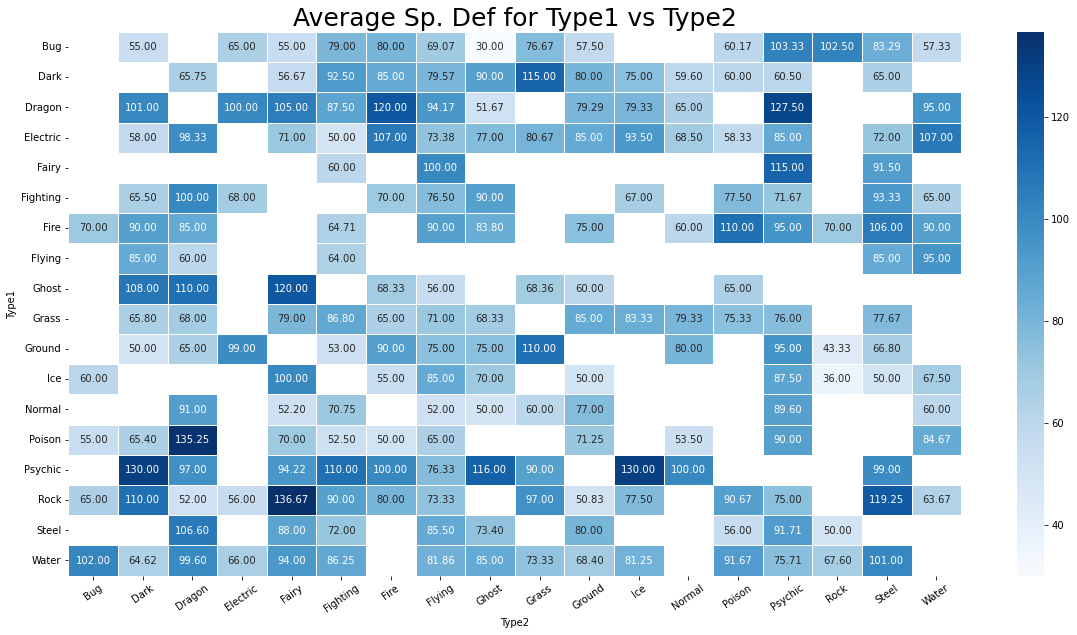

In [24]:
# Plot the heatmap for 'Sp. Def' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Sp. Def', figsize=(20, 10))

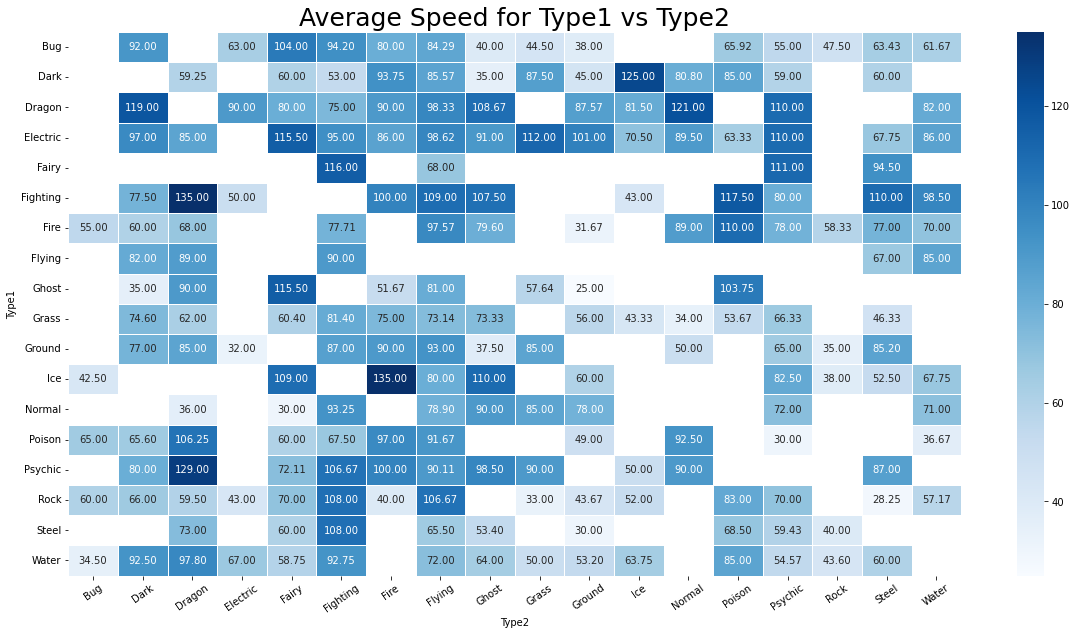

In [25]:
# Plot the heatmap for 'Speed' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Speed', figsize=(20, 10))


1. **`image_url`** : This column contains the URL of the Pokémon's image. It represents the web address where you can find and access the image file associated with each Pokémon.

2. **`Id`** : This column represents the unique identifier or ID of each Pokémon. Each Pokémon species is assigned a distinct ID for identification and reference purposes.

3. **`Names`** : This column contains the names of the Pokémon species. It represents the specific name given to each Pokémon, such as Bulbasaur, Ivysaur, Venusaur, or Venusaur Mega Venusaur.

4. **`Type1`** : This column denotes the primary type of the Pokémon. Pokémon can have one or two types, and `Type1` indicates the main or primary type of the Pokémon species. Examples include Grass, Fire, Water, Electric, etc.

5. **`Type2`** : This column denotes the secondary type of the Pokémon, if applicable. Some Pokémon have two types, and `Type2` indicates the secondary type. If a Pokémon has only one type, this column may be empty.

6. **`Total`** : This column represents the total base stat value of the Pokémon. The base stat total is the sum of all the Pokémon's individual base stats, including HP, Attack, Defense, Special Attack, Special Defense, and Speed. It provides an overall measure of a Pokémon's strength and capabilities.

7. **`HP`** :
   - HP represents a Pokémon's health or stamina. When a Pokémon's HP reaches zero, it faints and cannot battle further.
   - The HP stat determines how much damage a Pokémon can withstand before fainting.
   - HP can increase as a Pokémon levels up, and it can be influenced by other factors such as the base HP stat of the species, individual Pokémon's IVs (Individual Values), and effort values (EVs) gained through training.

8. **`Attack`** : 
      - Attack determines the strength of a Pokémon's physical moves, such as using its physical strength to hit opponents.
      - Base stats, IVs, and EVs also contribute to the final Attack values.



9. **`Defense`** : 
   - Defense determines how well a Pokémon can withstand physical attacks from opponents.
   - Base stats, IVs, and EVs also contribute to the final Defense values.


10. **`Sp. Atk`** 
    - Special Attack is a special combat stats of a Pokémon.
    - Special Attack determines the strength of a Pokémon's special moves, which involve using special powers, elements, or energy attacks.
    - Base stats, IVs, and EVs influence the final Special Attack values.

11. **`Sp. Def`** :
    - Special Defense is also a special combat stats of a Pokémon.
    - Special Defense determines a Pokémon's ability to withstand special attacks from opponents.
    - Base stats, IVs, and EVs influence the final Special Defense values.

12. **`Speed`** :
    - Speed determines the order in which Pokémon take their turns in battles. Pokémon with higher Speed stats generally move first.
    - Speed can play a crucial role in battle strategies, allowing Pokémon to attack first or outspeed opponents.
    - As with other stats, base stats, IVs, and EVs impact the final Speed value.
    
    
# N:

The base stats of a Pokémon, including HP, Attack, Defense, Special Attack, Special Defense, and Speed, are predetermined for each species. These base stats provide a foundation for the Pokémon's capabilities and differ between species.

In addition to base stats, individual Pokémon have IVs and EVs, which further affect their stats. IVs are hidden values that are unique to each Pokémon and are determined when a Pokémon is encountered or hatched. They provide additional stat bonuses. EVs, on the other hand, are earned by defeating specific Pokémon and can be used to train a Pokémon's stats in a particular way.

When Pokémon battle, their moves' power, type effectiveness, accuracy, and other factors come into play, in addition to the Pokémon's stats. The game mechanics and rules governing battles are defined by the Pokémon video games, with each iteration introducing slight variations and balance adjustments.



In Pokémon battles, the HP (Hit Points), Attack, Defense, Special Attack, Special Defense, and Speed stats play crucial roles. Here's an overview of how these stats work and how they are determined:

1. HP (Hit Points):
   - HP represents a Pokémon's health or stamina. When a Pokémon's HP reaches zero, it faints and cannot battle further.
   - The HP stat determines how much damage a Pokémon can withstand before fainting.
   - HP can increase as a Pokémon levels up, and it can be influenced by other factors such as the base HP stat of the species, individual Pokémon's IVs (Individual Values), and effort values (EVs) gained through training.

2. Attack and Defense:
   - Attack and Defense are the physical combat stats of a Pokémon.
   - Attack determines the strength of a Pokémon's physical moves, such as using its physical strength to hit opponents.
   - Defense determines how well a Pokémon can withstand physical attacks from opponents.
   - Base stats, IVs, and EVs also contribute to the final Attack and Defense values.

3. Special Attack and Special Defense:
   - Special Attack and Special Defense are the special combat stats of a Pokémon.
   - Special Attack determines the strength of a Pokémon's special moves, which involve using special powers, elements, or energy attacks.
   - Special Defense determines a Pokémon's ability to withstand special attacks from opponents.
   - Base stats, IVs, and EVs influence the final Special Attack and Special Defense values.

4. Speed:
   - Speed determines the order in which Pokémon take their turns in battles. Pokémon with higher Speed stats generally move first.
   - Speed can play a crucial role in battle strategies, allowing Pokémon to attack first or outspeed opponents.
   - As with other stats, base stats, IVs, and EVs impact the final Speed value.

The base stats of a Pokémon, including HP, Attack, Defense, Special Attack, Special Defense, and Speed, are predetermined for each species. These base stats provide a foundation for the Pokémon's capabilities and differ between species.

In addition to base stats, individual Pokémon have IVs and EVs, which further affect their stats. IVs are hidden values that are unique to each Pokémon and are determined when a Pokémon is encountered or hatched. They provide additional stat bonuses. EVs, on the other hand, are earned by defeating specific Pokémon and can be used to train a Pokémon's stats in a particular way.

When Pokémon battle, their moves' power, type effectiveness, accuracy, and other factors come into play, in addition to the Pokémon's stats. The game mechanics and rules governing battles are defined by the Pokémon video games, with each iteration introducing slight variations and balance adjustments.

